# Load Data

In [12]:
import os
from PIL import Image
import numpy as np
import torch
from torch.utils.data import DataLoader
from torchvision import transforms

# define custom torch dataset for torch dataloader

class Dataset(torch.utils.data.Dataset):

    def __init__(self, data_dir, transform=None):
        self.data_dir = data_dir
        self.transform = transform

        data = sorted(os.listdir(self.data_dir))

        img_list = []
        for f in sorted(data):
            if 'sample' in f:
                img_list.append(f) 

        self.img_list = img_list

    def __len__(self):
        return len(self.img_list)

    def __getitem__(self, index):

        input = Image.open(os.path.join(self.data_dir, self.img_list[index]))
        input = np.array(input)

        input = input/255.0
        input = input.astype(np.float32)

        if input.ndim == 2:
            input = input[:, :, np.newaxis]

        data = {'input': input}

        if self.transform:
            data = self.transform(data)

        return data

# preprocssing could be in transforms.Compose

class ToTensor(object):
    def __call__(self, data):
        input = data['input']

        input = input.transpose((2, 0, 1)).astype(np.float32)

        data = {'input': torch.from_numpy(input)}

        return data

class Normalization(object):
    def __init__(self, mean=0.5, std=0.5):
        self.mean = mean
        self.std = std

    def __call__(self, data):
        input = data['input']
        input = (input - self.mean) / self.std
        data = {'input': input}

        return data


data_dir = '/mnt/hdd1/c-MET_datasets/SLIDE_DATA/DL-based_tumor_seg_dataset'
batch_size = 16 # number of samples in an WSI (or a source image)

transform = transforms.Compose([Normalization(mean=0.5, std=0.5), ToTensor()])
dataset = Dataset(data_dir=os.path.join(data_dir, 'test'), transform = transform)
loader = DataLoader(dataset, batch_size = batch_size, shuffle=False)

In [13]:
x = dataset.__getitem__(0)
x['input'].size()

torch.Size([3, 256, 256])

# Model Inference

In [14]:
import torch
from model import UNet

def net_test_load(ckpt_dir, net, epoch = 0, device = torch.device('cuda:0')):
    if not os.path.exists(ckpt_dir): # 저장된 네트워크가 없다면 인풋을 그대로 반환
        epoch = 0
        return net
    
    ckpt_lst = os.listdir(ckpt_dir) # ckpt_dir 아래 있는 모든 파일 리스트를 받아온다
    ckpt_lst.sort(key = lambda f : int(''.join(filter(str.isdigit,f))))

    print(f'{ckpt_lst[epoch-1]}')
    dict_model = torch.load('%s/%s' % (ckpt_dir,ckpt_lst[epoch-1]), map_location=device)
    
    net.load_state_dict(dict_model['net'])

    return net

rank = 7
torch.cuda.set_device(rank)
device = torch.device(f'cuda:{rank}')

k_fold = 5
model_select = [94, 100, 83, 93, 93]
nets = []

for i in range(k_fold):
    print(f'{i+1}-fold - ', end = '')
    ckpt_dir = f'/mnt/hdd1/model/Lung_c-MET IHC_scored/UNet/{i+1}-fold/checkpoint'

    net = UNet().to(device)
    net = net_test_load(ckpt_dir = ckpt_dir, net = net, epoch = model_select[i], device=device)

    nets.append(net)


1-fold - model_epoch94.pth
2-fold - model_epoch100.pth
3-fold - model_epoch83.pth
4-fold - model_epoch93.pth
5-fold - model_epoch93.pth


In [15]:
fn_tonumpy = lambda x : x.to('cpu').detach().numpy().transpose(0, 2, 3, 1)
fn_denorm = lambda x, mean, std : (x*std) + mean
fn_norm = lambda x : (x-x.min())/(x.max()-x.min())
fn_classifier = lambda x : 1.0 * (x > 0.5)

results = []
with torch.no_grad(): 
    net.eval() 
    
    for batch, data in enumerate(loader, 1):
        # forward
        input = data['input'].to(device)
        
        outputs = []
        for net in nets:
            output = net(input)
            outputs.append(np.squeeze(fn_norm(fn_tonumpy(output)), axis=-1))

        input = fn_tonumpy(fn_denorm(input, mean=0.5, std=0.5))
        output_avg = np.mean(np.asarray(outputs), axis = 0)
        final_pred = fn_classifier(output_avg)

        results.append((input, final_pred, output_avg))

In [19]:
output_avg.shape

(16, 256, 256)

In [20]:
outputs[0][0].max(), outputs[0][0].min(), outputs[0][0].mean()

(0.9275444, 0.0, 0.34288862)

In [21]:
len(input)

16

In [25]:
import matplotlib.pyplot as plt
from matplotlib import cm

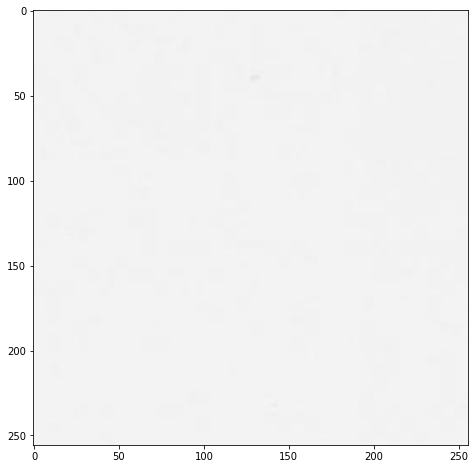

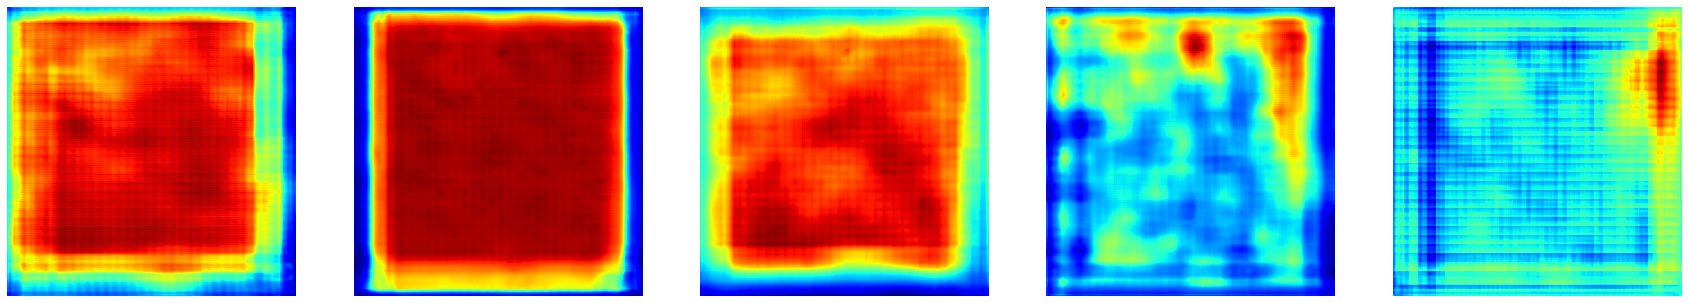

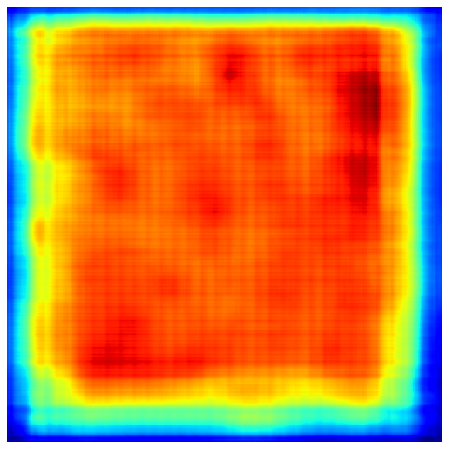

In [68]:
i = 11

plt.figure(figsize=(8, 8))
plt.imshow(input[i])
plt.axis('on')
plt.show()
plt.close()

plt.figure(figsize=(30, 30))
plt.subplot(1, 5, 1)
plt.imshow(outputs[0][i], cmap = 'jet')
plt.axis('off')
plt.subplot(1, 5, 2)
plt.imshow(outputs[1][i], cmap = 'jet')
plt.axis('off')
plt.subplot(1, 5, 3)
plt.imshow(outputs[2][i], cmap = 'jet')
plt.axis('off')
plt.subplot(1, 5, 4)
plt.imshow(outputs[3][i], cmap = 'jet')
plt.axis('off')
plt.subplot(1, 5, 5)
plt.imshow(outputs[4][i], cmap = 'jet')
plt.axis('off')
plt.show()
plt.close()

plt.figure(figsize=(8, 8))
plt.imshow(output_avg[i], cmap = 'jet')
plt.axis('off')
plt.show()
plt.close()


In [69]:
input[11]

array([[[0.9529412, 0.9529412, 0.9529412],
        [0.9529412, 0.9529412, 0.9529412],
        [0.9529412, 0.9529412, 0.9529412],
        ...,
        [0.9490196, 0.9490196, 0.9490196],
        [0.9490196, 0.9490196, 0.9490196],
        [0.9490196, 0.9490196, 0.9490196]],

       [[0.9529412, 0.9529412, 0.9529412],
        [0.9529412, 0.9529412, 0.9529412],
        [0.9529412, 0.9529412, 0.9529412],
        ...,
        [0.9490196, 0.9490196, 0.9490196],
        [0.9490196, 0.9490196, 0.9490196],
        [0.9490196, 0.9490196, 0.9490196]],

       [[0.9529412, 0.9529412, 0.9529412],
        [0.9529412, 0.9529412, 0.9529412],
        [0.9529412, 0.9529412, 0.9529412],
        ...,
        [0.9490196, 0.9490196, 0.9490196],
        [0.9490196, 0.9490196, 0.9490196],
        [0.9490196, 0.9490196, 0.9490196]],

       ...,

       [[0.9529412, 0.9529412, 0.9529412],
        [0.9529412, 0.9529412, 0.9529412],
        [0.9529412, 0.9529412, 0.9529412],
        ...,
        [0.9529412, 0.9529

In [41]:
import matplotlib.pyplot as plt
from PIL import Image
from matplotlib import cm

def make_heatmap(output):
    output = output-output.min()
    output = output/output.max()
    heatmap = cm.jet(output)
    return heatmap
    
save_dir = '/mnt/hdd1/model/Lung_c-MET IHC_scored/UNet/output_for_록원재단'

try: os.makedirs(save_dir)
except: pass

nrow, ncol = 4, 4

patch_level_performance = []
wsi_level_performance = []
for i, result in enumerate(results):

    # visualization on WSI (or source image)-level
    sample = np.empty((nrow*256, ncol*256, 3))
    predict = np.empty((nrow*256, ncol*256))
    output = np.empty((nrow*256, ncol*256))

    x, pred, prob = result
    
    for j, (x_j, pred_j, prob_j) in enumerate(zip(x, pred, prob)):
    
        row = j % nrow
        col = j // nrow

        sample[row*256:(row+1)*256, col*256:(col+1)*256, :] = x_j
        predict[row*256:(row+1)*256, col*256:(col+1)*256] = pred_j
        output[row*256:(row+1)*256, col*256:(col+1)*256] = prob_j


    plt.figure(figsize=(30, 30))
    plt.subplot(1, 3, 1)
    plt.imshow(sample)
    plt.axis('off')
    plt.subplot(1, 3, 2)
    plt.imshow(output, cmap = 'jet')
    plt.axis('off')
    plt.subplot(1, 3, 3)
    plt.imshow(predict*255, cmap='gray', vmax = 255, vmin = 0)
    plt.axis('off')
    plt.savefig(f'{save_dir}/{i+1}__plot.png', bbox_inches = 'tight')

    # plt.show()
    plt.close()

    sample = Image.fromarray(np.uint8(sample*255))
    predict = Image.fromarray(np.uint8(predict*255))
    heatmap = make_heatmap(output)
    heatmap = Image.fromarray(np.uint8(heatmap*255)).convert('RGB')

    # sample.save(f'{save_dir}/{i+1}_sample.jpg')
    # predict.save(f'{save_dir}/{i+1}_predict.jpg')
    # heatmap.save(f'{save_dir}/{i+1}_heatmap.jpg')
